# **Installing the Necessary Libraries**

In [1]:
!pip install tensorflow
!pip install bert-tensorflow
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-hub
!pip install transformers
!pip install bert-tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Importing the Needed Libraries**

In [2]:
import re
import nltk
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
from nltk.stem import WordNetLemmatizer
from nltk.corpus import gutenberg, stopwords, wordnet
from nltk.tokenize import regexp_tokenize
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
from bert import tokenization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense , Dropout
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')
import warnings
warnings.filterwarnings("ignore")


# **Downloading Some Needed Packages**

In [3]:
nltk.download('stopwords')
nltk.download('gutenberg')
nltk.download('punkt')
nltk.download('omw-1.4') 
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


**Function to get the Wordnet's Part of Speach for future use to lemmatize the words**

In [4]:
def get_word_net_pos(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("N"):
        return wordnet.NOUN
    elif tag.startswith("R"):
        return wordnet.ADV
    else :
        return wordnet.NOUN

**Function "read_book"**


*   It Takes 2 parameters the URL of the Book and the Name of the book
*   It Reads the Book, Decode, lower the Characters, Remove the Unnecessary characters, Remove the Stopwords, and Tokenize them


*   It Gets 200 Random Samples each Consists of 100 Word 
*   Then, Using the Previous "get_word_net_pos" Function we lemmatize the Tokens and Label the Book with its Author name 


*   Finally, We Return the Dataframe








In [5]:
def read_book(url,name) :
    lemmatizer = WordNetLemmatizer()
    response = request.urlopen(url)
    lines = (response.read().decode('utf8')).lower()
    book = regexp_tokenize(lines,r'([a-zA-Z]{3,})[\,|\s|\.]')
    tokens = [token for token in book if token.lower() not in stop_words]
    books =[]
    for i in range(200) :
        start = random.randint(0 , len(tokens) - 100)
        books.append([' '.join(tokens[start: start + 100])])    
    df = pd.DataFrame(books, columns=["partitions"])
    for i in range(200):
        sent=""
        x = nltk.pos_tag((df.partitions[i]).split())
        for word,tag in x:
            lemma = lemmatizer.lemmatize(word,pos=get_word_net_pos(tag))
            sent += lemma+" "
            df.partitions[i] = sent
    df["author"] = name
    return df

**Function "five_books"**


*   It Takes the List of URLs of the Books and the Authors Lisr as parameters
*   And for each URL it Reads the Book and Preprocess it as Above then Append all of the Dataframes into a Full Dataframe Contains all the Books Samples 



In [6]:
def five_books(list_of_urls,author_list) :
    df_full = pd.DataFrame()
    for i,j in enumerate(list_of_urls) :
        df = read_book(j,author_list[i])
        df_full = df_full.append(df , ignore_index= True)
    return df_full    

**Function "preprocess_text"**


*   Giving a Text and its Maximum Sequence Length, it Returns a 3 Lists Consists of :
      *   The Input IDs for the Text
      *   Its Attentiom Mask
      *   The Text Token Type IDs





In [7]:
def preprocess_text(text, max_seq_length):
    # Tokenize the text
    tokens = tokenizer.tokenize(text)
    # Add special tokens [CLS] and [SEP]
    tokens = ['[CLS]'] + tokens + ['[SEP]']
    
    # Convert tokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    
    # Pad or truncate the input IDs to the desired sequence length
    input_ids = input_ids[:max_seq_length]
    padding_length = max_seq_length - len(input_ids)
 
    input_ids = input_ids + [0] * padding_length
   

    # Create the attention mask
    attention_mask = [1] * len(input_ids)
    
    # Create the token type IDs
    token_type_ids = [0] * len(input_ids)
    
    return input_ids, attention_mask , token_type_ids


**Function "preprocess_df"**


*   It Takes Train and Test Dataframes 
*   It Returns a Tensor Type for the Whole Train Dataframe Preprocessed with the above Function 



In [8]:
def preprocess_df(x_df , y_df):

  max_seq_length = 100  # Set the desired maximum sequence length

  X_df_word_ids = []  # List to store preprocessed input IDs
  attention_masks = []  # List to store attention masks
  token_type_ids = []  # List to store token type IDs

  for text in x_df:
    input_ids, attention_mask , token_type_id= preprocess_text(text, max_seq_length)
    X_df_word_ids.append(input_ids)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)

  # Convert the lists to TensorFlow tensors
  X_df_word_ids = tf.convert_to_tensor(X_df_word_ids)
  attention_masks = tf.convert_to_tensor(attention_masks)
  token_type_ids = tf.convert_to_tensor(token_type_ids)

  y_train = y_df  # Your training labels
  return X_df_word_ids , attention_masks , token_type_ids , y_train


# Get 5 Books from Gutenberg Library 


*   The Project Gutenberg EBook of The Adventures of Pinocchio, by
C. Collodi--Pseudonym of Carlo Lorenzini

*   The Project Gutenberg eBook of Peter Pan, by James M. Barrie

*   The Project Gutenberg eBook of The Wonderful Wizard of Oz, by L. Frank Baum

*   The Project Gutenberg eBook of Alice’s Adventures in Wonderland, by Lewis Carroll

*   The Project Gutenberg eBook of Gulliver’s Travels, by Jonathan Swift








In [9]:
pinocchio = "https://www.gutenberg.org/files/500/500-0.txt"
pan = "https://www.gutenberg.org/files/16/16-0.txt"
oz = "https://www.gutenberg.org/files/55/55-0.txt"
alice = "https://www.gutenberg.org/files/11/11-0.txt"
gulliver = "https://www.gutenberg.org/files/829/829-0.txt"
books_list = [pinocchio , pan , oz , alice , gulliver]
author_list = ["Carlo Collodi", "James M. Barrie", "L. Frank Baum", "Lewis Carroll", "Jonathan Swift"]

In [10]:
df = five_books(books_list,author_list)

In [11]:
df

,partitions,author
0,faraway hill sob say fairy dear dear fairy die...,Carlo Collodi
1,order partridge pheasant couple rabbit dozen f...,Carlo Collodi
2,pinocchio walk door room reach remember donkey...,Carlo Collodi
3,climb back hold tightly neck take care everyth...,Carlo Collodi
4,believe everything hear allow catch easily tra...,Carlo Collodi
...,...,...
995,substance several conversation master great pa...,Jonathan Swift
996,country master say altogether past conception ...,Jonathan Swift
997,fail smart word two upon could revenge call br...,Jonathan Swift
998,introduce provocative drink except necessary p...,Jonathan Swift


In [12]:
df.author.value_counts()

Carlo Collodi      200
James M. Barrie    200
L. Frank Baum      200
Lewis Carroll      200
Jonathan Swift     200
Name: author, dtype: int64

**To Encode the Authors Names into Numerical Values**

In [13]:
encoder = LabelEncoder()
df.author = encoder.fit_transform(df.author)

In [14]:
df

,partitions,author
0,faraway hill sob say fairy dear dear fairy die...,0
1,order partridge pheasant couple rabbit dozen f...,0
2,pinocchio walk door room reach remember donkey...,0
3,climb back hold tightly neck take care everyth...,0
4,believe everything hear allow catch easily tra...,0
...,...,...
995,substance several conversation master great pa...,2
996,country master say altogether past conception ...,2
997,fail smart word two upon could revenge call br...,2
998,introduce provocative drink except necessary p...,2


In [15]:
df.author.value_counts()

0    200
1    200
3    200
4    200
2    200
Name: author, dtype: int64

**Split the Dataframes into Train and Test Splits**

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
        df['partitions'], df['author'], test_size=0.2, stratify=df['author'], random_state=42)

**Download the BERT-Base Model**

In [17]:
bert_model = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3"  # BERT base model
bert_layer = hub.KerasLayer(bert_model, trainable=False)


**Build the Model**


*  The Input will be a List of 3 inputs (word_ids, attention_mask, type_ids)
*   The Output will be 1 Value from the 5 Labels Classes 



In [35]:
input_word_ids = Input(shape=(100,), dtype=tf.int32, name="input_word_ids")
input_mask = Input(shape=(100,), dtype=tf.int32, name="input_mask")
input_type_ids = Input(shape=(100,), dtype=tf.int32, name="input_type_ids")

bert_output = bert_layer({"input_word_ids": input_word_ids, "input_mask": input_mask, "input_type_ids": input_type_ids})
dropout = Dropout(0.2)(bert_output["pooled_output"])
output = Dense(5, activation='softmax')(dropout)


model = Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=output)



**The Model Summary**


*   The total Parameters are almost 110 millions parameters but i stopped the trainable parameters
*   We got almost 4 thousand parameters to be trained 



In [36]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 100)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 100)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'pooled_output': (  109482241   ['input_mask[0][0]',             
                                None, 768),                       'input_type_ids[0][0]',   

**The Model Plot**


*   The 3 Inputs go through the Keras Layer then the Dropout to get the Output



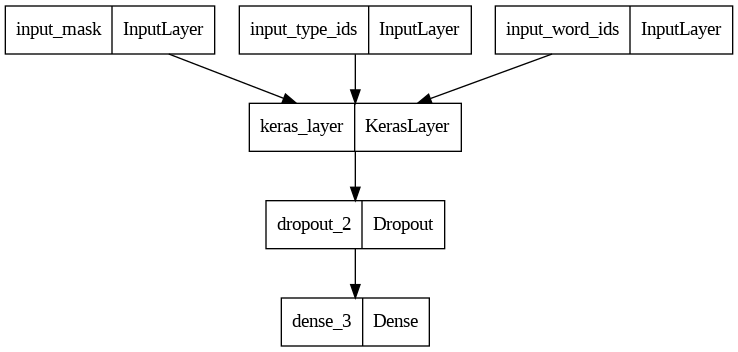

In [37]:
tf.keras.utils.plot_model(model)

**Preprocessing the Train Dataframe**

In [38]:
X_train_word_ids, attention_masks, token_type_ids , y_train = preprocess_df(X_train , y_train)

**Compiling the Model with ADAM Optimizer and sparse_categorical_crossentropy Loss Function and Accuracy Metric**

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=["accuracy"])

**Fitting the Model with the 3 Train Inputs and Y Train for a 100 Epochs with Batch Size equal 16 and Validation Ratio 20%**

In [45]:
history = model.fit([X_train_word_ids, attention_masks, token_type_ids], y_train, epochs = 100  , validation_split = 0.25 , batch_size=32 )

Epoch 1/100
19/19 [==============================] - 7s 399ms/step - loss: 0.6928 - accuracy: 0.7400 - val_loss: 0.6990 - val_accuracy: 0.7800
Epoch 2/100
19/19 [==============================] - 5s 293ms/step - loss: 0.6725 - accuracy: 0.7483 - val_loss: 0.6162 - val_accuracy: 0.8050
Epoch 3/100
19/19 [==============================] - 6s 299ms/step - loss: 0.6413 - accuracy: 0.7783 - val_loss: 0.6313 - val_accuracy: 0.8000
Epoch 4/100
19/19 [==============================] - 7s 363ms/step - loss: 0.6946 - accuracy: 0.7517 - val_loss: 0.6353 - val_accuracy: 0.8000
Epoch 5/100
19/19 [==============================] - 7s 367ms/step - loss: 0.6728 - accuracy: 0.7850 - val_loss: 0.6605 - val_accuracy: 0.7450
Epoch 6/100
19/19 [==============================] - 6s 297ms/step - loss: 0.6641 - accuracy: 0.7533 - val_loss: 0.6331 - val_accuracy: 0.7900
Epoch 7/100
19/19 [==============================] - 6s 298ms/step - loss: 0.6531 - accuracy: 0.7883 - val_loss: 0.6161 - val_accuracy: 0.8100

**Preprocess the Test Dataframe**

In [46]:
X_test_word_ids, test_attention_masks, test_token_type_ids , y_test = preprocess_df(X_test , y_test)

**Evaluate the Model with the Test Data**

In [47]:
loss, accuracy = model.evaluate([X_test_word_ids, test_attention_masks, test_token_type_ids], y_test)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

7/7 [==============================] - 1s 191ms/step - loss: 0.7769 - accuracy: 0.7250
Test Loss: 0.7768750190734863
Test Accuracy: 0.7250000238418579


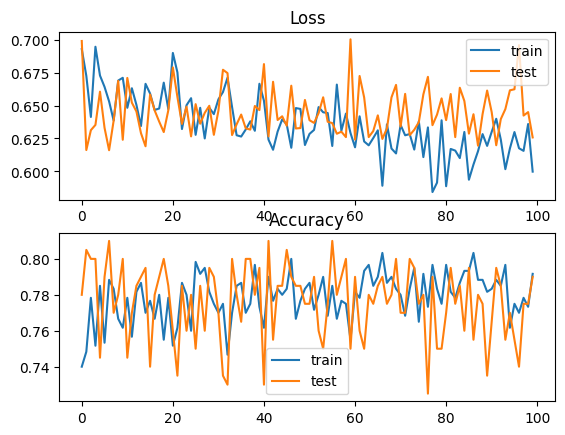

In [49]:
# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show()

**Save the Model and the Model's Weights for Future use**

In [50]:
# Save the model and the weights of the model
model.save('./my_model')
model.save_weights('model_weights.h5')


In [28]:
# from tensorflow.keras.models import load_model

# # Load the saved model
# loaded_model = load_model('./my_model')

# Load the saved weights into the model
# model.load_weights('model_weights.h5')

# # Use the loaded model for prediction or evaluation
# predictions = loaded_model.predict([X_test_word_ids, attention_masks_test, token_type_ids_test])
